# Scripts to produce all figures of the main article

Copyright 2017: Frank Stollmeier

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.

## Preparations

In [1]:
import random
import numpy as np
import pyximport; pyximport.install()
from algorithms import *
import pylab as pl
%matplotlib inline
import networkx as nx
from ipywidgets import FloatProgress
from IPython.display import display
dview = None

If you like to run the simulations in parallel using [ipyparallel](https://ipyparallel.readthedocs.io/en/latest/index.html), start the controller and the engines, enter the profile name below, and execute the following cell.
If you skip the following cell, everything will run on the local kernel. Without parallelization it may take hours to get accurate results, but you can get less accurate results quickly if you reduce the number of simulations with the parameters n_graphs and n_runs.

In [ ]:
from ipyparallel import Client
clients = Client(profile='ssh')
print 'Engines: ', clients.ids
clients.block = True
dview = clients.direct_view()
dview.execute('''
import random
import numpy as np
import networkx as nx
import pyximport; pyximport.install()
from algorithms import *
''')

If you don't want to run any simulations at all but just plot and inspect the results you can load saved data by executing the following cell. Then you can skip all cells which start with the comment '#simulation'.

In [2]:
import pickle
f = open('fixation_probabilities.dat' ,'r')
datadict = pickle.load(f)

#Data of the simulations for finding the right value for the costs
fixation_probabilities_cost_estimation = datadict['fixation_probabilities_cost_estimation']
#Data of the birth-death process for different graph types
circle_fixation_probabilities_100 = datadict['circle_fixation_probabilities_100']
circle_fixation_probabilities_500 = datadict['circle_fixation_probabilities_500'] 
lattice_fixation_probabilities_100 = datadict['lattice_fixation_probabilities_100']
lattice_fixation_probabilities_500 = datadict['lattice_fixation_probabilities_500']
random_regular_fixation_probabilities_100 = datadict['random_regular_fixation_probabilities_100']
random_regular_fixation_probabilities_500 = datadict['random_regular_fixation_probabilities_500']
random_fixation_probabilities_100 = datadict['random_fixation_probabilities_100']
random_fixation_probabilities_500 = datadict['random_fixation_probabilities_500']
scalefree_fixation_probabilities_100 = datadict['scalefree_fixation_probabilities_100']
scalefree_fixation_probabilities_500 = datadict['scalefree_fixation_probabilities_500']
#Data of the imitation process for different graph types
circle_fixation_probabilities_100_IM = datadict['circle_fixation_probabilities_100_IM']
lattice_fixation_probabilities_100_IM = datadict['lattice_fixation_probabilities_100_IM']
random_regular_fixation_probabilities_100_IM = datadict['random_regular_fixation_probabilities_100_IM']
random_fixation_probabilities_100_IM = datadict['random_fixation_probabilities_100_IM']
scalefree_fixation_probabilities_100_IM = datadict['scalefree_fixation_probabilities_100_IM']

f.close()

## Effect of absolute values for the benefits and costs on the fixation probability curves

In [3]:
#parameters and functions

N = 500
k = 10
w = 0.01
n_graphs = 1000
n_runs = 1000
#For quick and less accurranate results choose smaller numbers, e.g.
#n_graphs = 100
#n_runs = 500

cost_values = [0.05,0.10,0.125,0.15,0.2]
benefit_to_cost_ratio_cost_estimation = np.linspace(7,17,8)

def circle_graph_generator(N,k):
    G = nx.newman_watts_strogatz_graph(N,k,0)
    return convert_networkx_graph_to_adjacency_list(G)

#For comparison, the following data is taken from Ohtsuki et al., Figure 2 a (circle graph, N=500, k=10)
ohtsuki_bc = [7.66592,8.31695,9.08119,9.98697,11.11918,12.47784,14.26108,16.66704]
ohtsuki_fp = [0.00020,0.00061,0.00111,0.00179,0.00259,0.00360,0.00488,0.00649]

In [11]:
#simulation

fixation_probabilities_cost_estimation = []
fp = FloatProgress(min=0,max=len(cost_values))
display(fp)
for c in cost_values:
    fixation_probabilities_cost_estimation.append( measure_fixation_probabilities(circle_graph_generator,[N,k],w,c,n_graphs,n_runs,benefit_to_cost_ratio_cost_estimation,dview=dview)) 
    fp.value += 1

(6.5, 17.5)

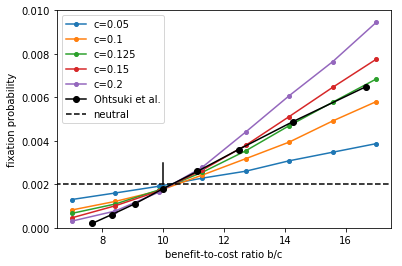

In [4]:
#visualization

pl.rcParams['figure.figsize'] = (6,4)
#pl.style.use('./style1plot.mplstyle')

xdata = np.linspace(1,21,10)
arrow_length = 0.001
threshold = 1/float(N)
pl.plot([10,10],[threshold+arrow_length,threshold],'k')
for c,fp in zip(cost_values,fixation_probabilities_cost_estimation):
    pl.plot(benefit_to_cost_ratio_cost_estimation, fp,'o-', markersize=4, label='c='+str(c))

pl.plot(ohtsuki_bc,ohtsuki_fp,'ko-', label='Ohtsuki et al.')
pl.plot(xdata, threshold*np.ones(len(xdata)),'k--',label='neutral')
pl.xlim(benefit_to_cost_ratio_cost_estimation[0],benefit_to_cost_ratio_cost_estimation[-1])
pl.ylim(0,0.01)
pl.legend(loc='upper left')
pl.xlabel('benefit-to-cost ratio b/c')
pl.ylabel('fixation probability')
pl.xlim(6.5,17.5)
#pl.savefig('cost_value_estimation.svg')

## Fixation probabilities of the death-birth process

In [7]:
#parameters and functions

w = 0.01
c = 0.125
n_graphs = 1000
n_runs = 1000
#For quick and less accurate results choose smaller numbers, e.g.
#n_graphs = 100
#n_runs = 500

xdata = np.linspace(1,21,10)
arrow_length = 0.001
markeredgecolordict = {2:'red',3:'orange',4:'yellow',6:'green',8:'cyan',10:'blue'}
markerfacecolordict = {2:'red',3:'none',4:'none',6:'none',8:'cyan',10:'blue'}
markerdict = {2:'+',3:'^',4:'s',6:'H',8:'s',10:'D'}

n_datapoints = 10
benefit_to_cost_ratios = dict()
benefit_to_cost_ratios[2] = np.linspace(1.2,4,n_datapoints)
benefit_to_cost_ratios[3] = np.linspace(1.5,5,n_datapoints)
benefit_to_cost_ratios[4] = np.linspace(2,6,n_datapoints) 
benefit_to_cost_ratios[6] = np.linspace(4,9,n_datapoints)
benefit_to_cost_ratios[8] = np.linspace(4,14,n_datapoints)
benefit_to_cost_ratios[10] = np.linspace(8,20,n_datapoints)

def measure_fixation_probabilities_for_list_of_k_and_bc_values(graph_generator, N, k_values, n_graphs, n_runs):
    fp = FloatProgress(min=0,max=len(k_values))
    display(fp)
    fixation_probabilities = []
    for k in k_values:
        bc = benefit_to_cost_ratios[k]
        fixation_probabilities.append(measure_fixation_probabilities(graph_generator,[N,k],w,c,n_graphs,n_runs,bc,dview=dview))
        fp.value += 1
    return fixation_probabilities

### Circle graph

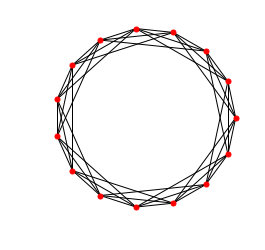

In [34]:
#illustration of the graph type

pl.figure(figsize=(3,3))
N = 15
G = nx.newman_watts_strogatz_graph(N,6,0)
positions = dict([(n,(np.cos(2*np.pi*n/float(N)),np.sin(2*np.pi*n/float(N)))) for n in G.nodes()])
nx.draw(G,pos = positions, node_size = 25)

In [13]:
#parameters and functions

circle_k_values = [2,4,6,10]

def circle_graph_generator(N,k):
    G = nx.newman_watts_strogatz_graph(N,k,0)
    return convert_networkx_graph_to_adjacency_list(G)

In [18]:
#simulation

N = 100
circle_fixation_probabilities_100 = measure_fixation_probabilities_for_list_of_k_and_bc_values(circle_graph_generator, N, circle_k_values, n_graphs, n_runs)

In [19]:
#simulation

N = 500
circle_fixation_probabilities_500 = measure_fixation_probabilities_for_list_of_k_and_bc_values(circle_graph_generator, N, circle_k_values, n_graphs, n_runs)

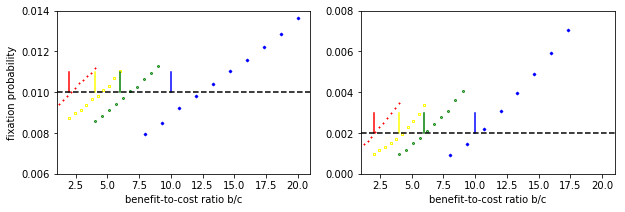

In [14]:
#visualization

pl.rcParams['figure.figsize'] = (10,3)
#pl.style.use('./style2plots.mplstyle') #to produce figures for the paper

pl.subplot(1,2,1)

for k,fp in zip(circle_k_values, circle_fixation_probabilities_100):
    pl.plot(benefit_to_cost_ratios[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k,k], [1/100.0 + arrow_length,1/100.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/100.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0.006,0.014)
pl.yticks([0.006,0.008,0.010,0.012,0.014])
pl.ylabel("fixation probability")
pl.xlabel("benefit-to-cost ratio b/c")


pl.subplot(1,2,2)
for k,fp in zip(circle_k_values, circle_fixation_probabilities_500):
    pl.plot(benefit_to_cost_ratios[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k,k], [1/500.0 + arrow_length,1/500.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/500.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0,0.008)
pl.yticks([0,0.002,0.004,0.006,0.008])
pl.xlabel("benefit-to-cost ratio b/c")

#pl.savefig('fixation_probabilities_circle.svg')

### Lattice graph

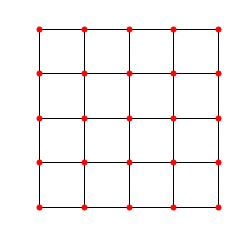

In [15]:
#illustration of the graph type

pl.figure(figsize=(3,3))
G = nx.grid_graph(dim=[5,5])
positions = dict([(n,n) for n in G.nodes()])
nx.draw(G,pos=positions, node_size = 25)

In [16]:
#parameters and functions

def lattice_graph3(N1,N2):
    G = create_hexagonal_lattice_graph(N1,N2)
    return convert_networkx_graph_to_adjacency_list(G)
def lattice_graph4(N1,N2):
    G = create_square_lattice_graph4(N1,N2)
    return convert_networkx_graph_to_adjacency_list(G)
def lattice_graph6(N1,N2):
    G = create_square_lattice_graph6(N1,N2)
    return convert_networkx_graph_to_adjacency_list(G)
def lattice_graph8(N1,N2):
    G = create_triangular_lattice_graph(N1,N2)
    return convert_networkx_graph_to_adjacency_list(G)

lattice_k_values = [3,4,6,8]

In [23]:
#simulation

N = 100

fp = FloatProgress(min=0,max=4)
display(fp)

lattice_fixation_probabilities3_100 = measure_fixation_probabilities(lattice_graph3,[10,15],w,c,n_graphs,n_runs,benefit_to_cost_ratios[3],dview=dview)
fp.value += 1

lattice_fixation_probabilities4_100 = measure_fixation_probabilities(lattice_graph4,[10,10],w,c,n_graphs,n_runs,benefit_to_cost_ratios[4],dview=dview)
fp.value += 1

lattice_fixation_probabilities6_100 = measure_fixation_probabilities(lattice_graph6,[10,10],w,c,n_graphs,n_runs,benefit_to_cost_ratios[6],dview=dview)
fp.value += 1

lattice_fixation_probabilities8_100 = measure_fixation_probabilities(lattice_graph8,[10,10],w,c,n_graphs,n_runs,benefit_to_cost_ratios[8],dview=dview)
fp.value += 1

lattice_fixation_probabilities_100 = [lattice_fixation_probabilities3_100, lattice_fixation_probabilities4_100, lattice_fixation_probabilities6_100, lattice_fixation_probabilities8_100]

In [24]:
#simulation

N = 500

fp = FloatProgress(min=0,max=4)
display(fp)

lattice_fixation_probabilities3_500 = measure_fixation_probabilities(lattice_graph3,[25,30],w,c,n_graphs,n_runs,benefit_to_cost_ratios[3],dview=dview)
fp.value += 1

lattice_fixation_probabilities4_500 = measure_fixation_probabilities(lattice_graph4,[20,25],w,c,n_graphs,n_runs,benefit_to_cost_ratios[4],dview=dview)
fp.value += 1

lattice_fixation_probabilities6_500 = measure_fixation_probabilities(lattice_graph6,[20,25],w,c,n_graphs,n_runs,benefit_to_cost_ratios[6],dview=dview)
fp.value += 1

lattice_fixation_probabilities8_500 = measure_fixation_probabilities(lattice_graph8,[20,25],w,c,n_graphs,n_runs,benefit_to_cost_ratios[8],dview=dview)
fp.value += 1

lattice_fixation_probabilities_500 = [lattice_fixation_probabilities3_500, lattice_fixation_probabilities4_500, lattice_fixation_probabilities6_500, lattice_fixation_probabilities8_500]

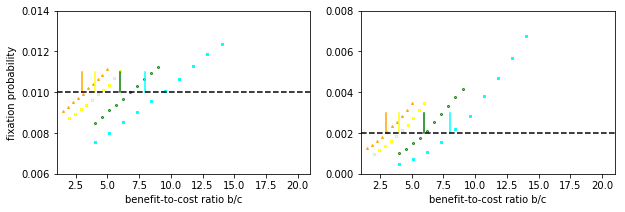

In [17]:
#visualization

pl.rcParams['figure.figsize'] = (10,3)
#pl.style.use('./style2plots.mplstyle') #to produce figures for the paper

pl.subplot(1,2,1)

for k,fp in zip(lattice_k_values, lattice_fixation_probabilities_100):
    pl.plot(benefit_to_cost_ratios[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k,k], [1/100.0 + arrow_length,1/100.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/100.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0.006,0.014)
pl.yticks([0.006,0.008,0.010,0.012,0.014])
pl.ylabel("fixation probability")
pl.xlabel("benefit-to-cost ratio b/c")


pl.subplot(1,2,2)
for k,fp in zip(lattice_k_values, lattice_fixation_probabilities_500):
    pl.plot(benefit_to_cost_ratios[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k,k], [1/500.0 + arrow_length,1/500.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/500.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0,0.008)
pl.yticks([0,0.002,0.004,0.006,0.008])
pl.xlabel("benefit-to-cost ratio b/c")

#pl.savefig('fixation_probabilities_lattice.svg')

### Random regular graph

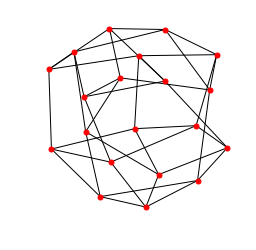

In [18]:
#illustration of the graph type

pl.figure(figsize=(3,3))
G = nx.random_regular_graph(4,20) 
nx.draw(G, node_size = 25)

In [19]:
#parameters and functions

random_regular_k_values = [3,4,6,10]

def random_regular_graph_generator(N,k):
    G = nx.random_regular_graph(k,N) 
    while not nx.is_connected(G):
        G = nx.random_regular_graph(k,N)
    return convert_networkx_graph_to_adjacency_list(G)

In [28]:
#simulation

N = 100
random_regular_fixation_probabilities_100 = measure_fixation_probabilities_for_list_of_k_and_bc_values(random_regular_graph_generator, N, random_regular_k_values, n_graphs, n_runs)

In [29]:
#simulation

N = 500
random_regular_fixation_probabilities_500 = measure_fixation_probabilities_for_list_of_k_and_bc_values(random_regular_graph_generator, N, random_regular_k_values, n_graphs, n_runs)

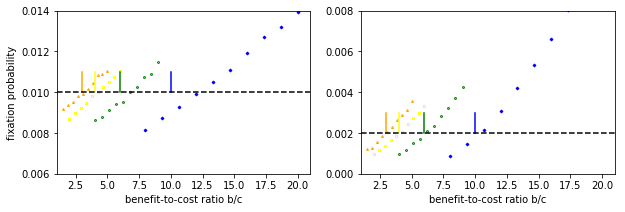

In [20]:
#visualization

pl.rcParams['figure.figsize'] = (10,3)
#pl.style.use('./style2plots.mplstyle') #to produce figures for the paper

pl.subplot(1,2,1)

for k,fp in zip(random_regular_k_values, random_regular_fixation_probabilities_100):
    pl.plot(benefit_to_cost_ratios[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k,k], [1/100.0 + arrow_length,1/100.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/100.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0.006,0.014)
pl.yticks([0.006,0.008,0.010,0.012,0.014])
pl.ylabel("fixation probability")
pl.xlabel("benefit-to-cost ratio b/c")


pl.subplot(1,2,2)
for k,fp in zip(random_regular_k_values, random_regular_fixation_probabilities_500):
    pl.plot(benefit_to_cost_ratios[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k,k], [1/500.0 + arrow_length,1/500.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/500.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0,0.008)
pl.yticks([0,0.002,0.004,0.006,0.008])
pl.xlabel("benefit-to-cost ratio b/c")

#pl.savefig('fixation_probabilities_random_regular.svg')

### Random graph

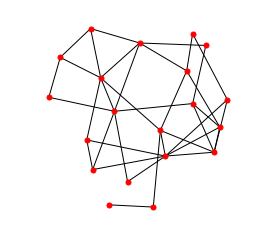

In [21]:
#illustration of the graph type

pl.figure(figsize=(3,3))
G = create_connected_random_graph(20,4)
nx.draw(G, node_size = 25)

In [22]:
#parameters and functions

def random_graph_generator(N,k):
    G = create_connected_random_graph(N,k)
    return convert_networkx_graph_to_adjacency_list(G)

random_k_values = [3,4,6,10]

In [33]:
#simulations

N = 100
random_fixation_probabilities_100 = measure_fixation_probabilities_for_list_of_k_and_bc_values(random_graph_generator, N, random_k_values, n_graphs, n_runs)

In [34]:
#simulations

N = 500
random_fixation_probabilities_500 = measure_fixation_probabilities_for_list_of_k_and_bc_values(random_graph_generator, N, random_k_values, n_graphs, n_runs)

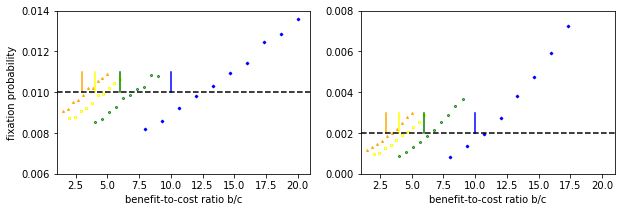

In [23]:
#visualization

pl.rcParams['figure.figsize'] = (10,3)
#pl.style.use('./style2plots.mplstyle') #to produce figures for the paper

pl.subplot(1,2,1)

for k,fp in zip(random_k_values, random_fixation_probabilities_100):
    pl.plot(benefit_to_cost_ratios[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k,k], [1/100.0 + arrow_length,1/100.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/100.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0.006,0.014)
pl.yticks([0.006,0.008,0.010,0.012,0.014])
pl.ylabel("fixation probability")
pl.xlabel("benefit-to-cost ratio b/c")


pl.subplot(1,2,2)
for k,fp in zip(random_k_values, random_fixation_probabilities_500):
    pl.plot(benefit_to_cost_ratios[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k,k], [1/500.0 + arrow_length,1/500.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/500.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0,0.008)
pl.yticks([0,0.002,0.004,0.006,0.008])
pl.xlabel("benefit-to-cost ratio b/c")

#pl.savefig('fixation_probabilities_random.svg')

### Scale-free network

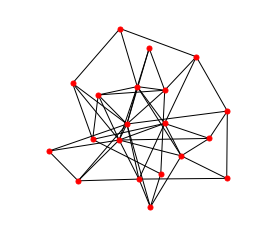

In [24]:
#illustration of the graph type

pl.figure(figsize=(3,3))
G = nx.barabasi_albert_graph(20,6/2)
nx.draw(G, node_size = 25)

In [25]:
#parameters and functions

def scalefree_graph_generator(N,k):
    G = nx.barabasi_albert_graph(N,k/2)
    while not nx.is_connected(G):
        G = nx.barabasi_albert_graph(N,k/2)
    return convert_networkx_graph_to_adjacency_list(G)

scalefree_k_values = [2,4,6,10]

In [38]:
#simulation

N = 100
scalefree_fixation_probabilities_100 = measure_fixation_probabilities_for_list_of_k_and_bc_values(scalefree_graph_generator, N, scalefree_k_values, n_graphs, n_runs)

In [39]:
#simulation

N = 500
scalefree_fixation_probabilities_500 = measure_fixation_probabilities_for_list_of_k_and_bc_values(scalefree_graph_generator, N, scalefree_k_values, n_graphs, n_runs)

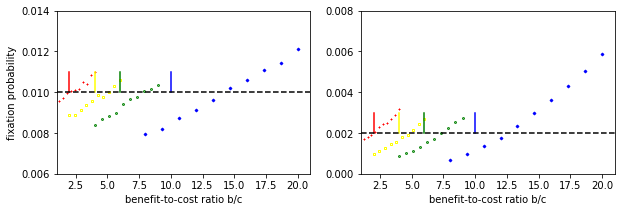

In [26]:
#visualization

pl.rcParams['figure.figsize'] = (10,3)
#pl.style.use('./style2plots.mplstyle') #to produce figures for the paper

pl.subplot(1,2,1)

for k,fp in zip(scalefree_k_values, scalefree_fixation_probabilities_100):
    pl.plot(benefit_to_cost_ratios[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k,k], [1/100.0 + arrow_length,1/100.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/100.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0.006,0.014)
pl.yticks([0.006,0.008,0.010,0.012,0.014])
pl.ylabel("fixation probability")
pl.xlabel("benefit-to-cost ratio b/c")


pl.subplot(1,2,2)
for k,fp in zip(scalefree_k_values, scalefree_fixation_probabilities_500):
    pl.plot(benefit_to_cost_ratios[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k,k], [1/500.0 + arrow_length,1/500.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/500.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0,0.008)
pl.yticks([0,0.002,0.004,0.006,0.008])
pl.xlabel("benefit-to-cost ratio b/c")

#pl.savefig('fixation_probabilities_scalefree.svg')

## Fixation probabilities for the imitation process

In [27]:
#parameters and functions

w = 0.01
c = 0.125
n_graphs = 1000
n_runs = 1000
#For quick and less accurate results choose smaller numbers, e.g.
#n_graphs = 100
#n_runs = 500

xdata = np.linspace(1,21,10)
arrow_length = 0.001
markeredgecolordict = {2:'red',3:'orange',4:'yellow',6:'green',8:'cyan',10:'blue'}
markerfacecolordict = {2:'red',3:'none',4:'none',6:'none',8:'cyan',10:'blue'}
markerdict = {2:'+',3:'^',4:'s',6:'H',8:'s',10:'D'}

n_datapoints = 10
benefit_to_cost_ratios_IM = dict()
benefit_to_cost_ratios_IM[2] = np.linspace(3.2,6,n_datapoints)
benefit_to_cost_ratios_IM[3] = np.linspace(3.5,7,n_datapoints)
benefit_to_cost_ratios_IM[4] = np.linspace(4,8,n_datapoints) 
benefit_to_cost_ratios_IM[6] = np.linspace(6,13,n_datapoints)
benefit_to_cost_ratios_IM[8] = np.linspace(7,20,n_datapoints)
benefit_to_cost_ratios_IM[10] = np.linspace(10,22,n_datapoints)

def measure_fixation_probabilities_for_list_of_k_and_bc_values_IM(graph_generator, N, k_values, n_graphs, n_runs):
    fp = FloatProgress(min=0,max=len(k_values))
    display(fp)
    fixation_probabilities = []
    for k in k_values:
        bc = benefit_to_cost_ratios_IM[k]
        fixation_probabilities.append(measure_fixation_probabilities(graph_generator,[N,k],w,c,n_graphs,n_runs,bc,dview=dview, iteration_type = 0))
        fp.value += 1
    return fixation_probabilities

### Circle and lattice graph

In [28]:
#parameters and functions

def circle_graph_generator(N,k):
    G = nx.newman_watts_strogatz_graph(N,k,0)
    return convert_networkx_graph_to_adjacency_list(G)

circle_k_values = [2,4,6,10]

def lattice_graph3(N1,N2):
    G = create_hexagonal_lattice_graph(N1,N2)
    return convert_networkx_graph_to_adjacency_list(G)
def lattice_graph4(N1,N2):
    G = create_square_lattice_graph4(N1,N2)
    return convert_networkx_graph_to_adjacency_list(G)
def lattice_graph6(N1,N2):
    G = create_square_lattice_graph6(N1,N2)
    return convert_networkx_graph_to_adjacency_list(G)
def lattice_graph8(N1,N2):
    G = create_triangular_lattice_graph(N1,N2)
    return convert_networkx_graph_to_adjacency_list(G)

lattice_k_values = [3,4,6,8]

In [66]:
#simulation

N = 100
circle_fixation_probabilities_100_IM = measure_fixation_probabilities_for_list_of_k_and_bc_values_IM(circle_graph_generator, N, circle_k_values, n_graphs, n_runs)

In [68]:
#simulation

N = 100

fp = FloatProgress(min=0,max=4)
display(fp)

lattice_fixation_probabilities3_100_IM = measure_fixation_probabilities(lattice_graph3,[10,15],w,c,n_graphs,n_runs,benefit_to_cost_ratios_IM[3],dview=dview, iteration_type = 0)
fp.value += 1

lattice_fixation_probabilities4_100_IM = measure_fixation_probabilities(lattice_graph4,[10,10],w,c,n_graphs,n_runs,benefit_to_cost_ratios_IM[4],dview=dview, iteration_type = 0)
fp.value += 1

lattice_fixation_probabilities6_100_IM = measure_fixation_probabilities(lattice_graph6,[10,10],w,c,n_graphs,n_runs,benefit_to_cost_ratios_IM[6],dview=dview, iteration_type = 0)
fp.value += 1

lattice_fixation_probabilities8_100_IM = measure_fixation_probabilities(lattice_graph8,[10,10],w,c,n_graphs,n_runs,benefit_to_cost_ratios_IM[8],dview=dview, iteration_type = 0)
fp.value += 1

lattice_fixation_probabilities_100_IM = [lattice_fixation_probabilities3_100_IM, lattice_fixation_probabilities4_100_IM, lattice_fixation_probabilities6_100_IM, lattice_fixation_probabilities8_100_IM]

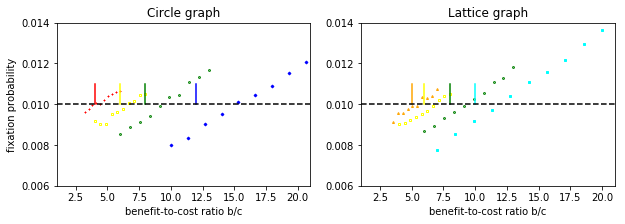

In [29]:
#visualization

pl.rcParams['figure.figsize'] = (10,3)
#pl.style.use('./style2plots.mplstyle') #to produce figures for the paper

pl.subplot(1,2,1)
pl.title("Circle graph")
for k,fp in zip(circle_k_values, circle_fixation_probabilities_100_IM):
    pl.plot(benefit_to_cost_ratios_IM[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k+2,k+2], [1/100.0 + arrow_length,1/100.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/100.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0.006,0.014)
pl.yticks([0.006,0.008,0.010,0.012,0.014])
pl.ylabel("fixation probability")
pl.xlabel("benefit-to-cost ratio b/c")

pl.subplot(1,2,2)
pl.title("Lattice graph")
for k,fp in zip(lattice_k_values, lattice_fixation_probabilities_100_IM):
    pl.plot(benefit_to_cost_ratios_IM[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k+2,k+2], [1/100.0 + arrow_length,1/100.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/100.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0.006,0.014)
pl.yticks([0.006,0.008,0.010,0.012,0.014])
pl.xlabel("benefit-to-cost ratio b/c")

#pl.savefig('fixation_probabilities_imitation_circle_and_lattice.svg')

### Random regular graph and random graph

In [30]:
#parameters and functions 

def random_regular_graph_generator(N,k):
    G = nx.random_regular_graph(k,N) 
    while not nx.is_connected(G):
        G = nx.random_regular_graph(k,N)
    return convert_networkx_graph_to_adjacency_list(G)

random_regular_k_values = [3,4,6,10]

def random_graph_generator(N,k):
    G = create_connected_random_graph(N,k)
    return convert_networkx_graph_to_adjacency_list(G)

random_k_values = [3,4,6,10]

In [71]:
#simulation

N = 100
random_regular_fixation_probabilities_100_IM = measure_fixation_probabilities_for_list_of_k_and_bc_values_IM(random_regular_graph_generator, N, random_regular_k_values, n_graphs, n_runs)

In [73]:
#simulation

N = 100
random_fixation_probabilities_100_IM = measure_fixation_probabilities_for_list_of_k_and_bc_values_IM(random_graph_generator, N, random_k_values, n_graphs, n_runs)

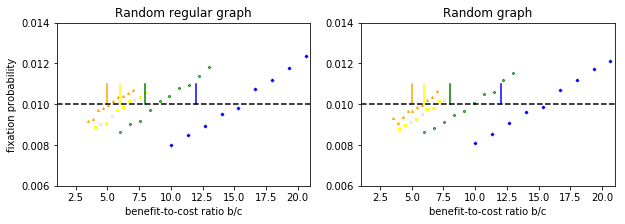

In [31]:
#visualization

pl.rcParams['figure.figsize'] = (10,3)
#pl.style.use('./style2plots.mplstyle') #to produce figures for the paper

pl.subplot(1,2,1)
pl.title("Random regular graph")
for k,fp in zip(random_regular_k_values, random_regular_fixation_probabilities_100_IM):
    pl.plot(benefit_to_cost_ratios_IM[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k+2,k+2], [1/100.0 + arrow_length,1/100.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/100.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0.006,0.014)
pl.yticks([0.006,0.008,0.010,0.012,0.014])
pl.ylabel("fixation probability")
pl.xlabel("benefit-to-cost ratio b/c")

pl.subplot(1,2,2)
pl.title("Random graph")
for k,fp in zip(random_k_values, random_fixation_probabilities_100_IM):
    pl.plot(benefit_to_cost_ratios_IM[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k+2,k+2], [1/100.0 + arrow_length,1/100.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/100.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0.006,0.014)
pl.yticks([0.006,0.008,0.010,0.012,0.014])
pl.xlabel("benefit-to-cost ratio b/c")

#pl.savefig('fixation_probabilities_imitation_randomregular_and_random.svg')

### Scale-free graph

In [32]:
#parameters and functions

def scalefree_graph_generator(N,k):
    G = nx.barabasi_albert_graph(N,k/2) # with k=2,4,6,10
    while not nx.is_connected(G):
        G = nx.barabasi_albert_graph(N,k/2)
    return convert_networkx_graph_to_adjacency_list(G)

scalefree_k_values = [2,4,6,10]

In [76]:
#simulation

N = 100
scalefree_fixation_probabilities_100_IM = measure_fixation_probabilities_for_list_of_k_and_bc_values_IM(scalefree_graph_generator, N, scalefree_k_values, n_graphs, n_runs)

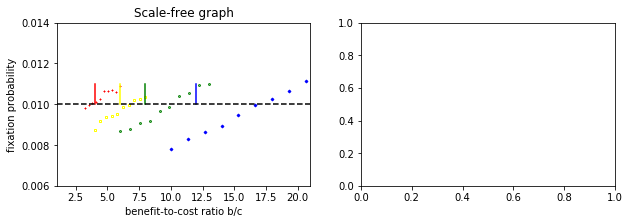

In [33]:
#visualization

pl.rcParams['figure.figsize'] = (10,3)
#pl.style.use('./style2plots.mplstyle') #to produce figures for the paper

pl.subplot(1,2,1)
pl.title("Scale-free graph")
for k,fp in zip(scalefree_k_values, scalefree_fixation_probabilities_100_IM):
    pl.plot(benefit_to_cost_ratios_IM[k], fp, marker=markerdict[k], markersize = 2, markeredgewidth=1, markeredgecolor=markeredgecolordict[k], markerfacecolor=markerfacecolordict[k] ,linestyle='None')
    pl.plot([k+2,k+2], [1/100.0 + arrow_length,1/100.0], color=markeredgecolordict[k])

pl.plot(xdata, np.ones(len(xdata))/100.0,'k--',label='neutral')

pl.xlim(1,21)
pl.ylim(0.006,0.014)
pl.yticks([0.006,0.008,0.010,0.012,0.014])
pl.ylabel("fixation probability")
pl.xlabel("benefit-to-cost ratio b/c")

pl.subplot(1,2,2)

#pl.savefig('fixation_probabilities_imitation_scalefree.svg')

## Save results

In [ ]:
import pickle
f = open(filename ,'w')

datadict = dict()
#Data of the simulations for finding the right value for the costs
datadict['fixation_probabilities_cost_estimation'] = fixation_probabilities_cost_estimation
#Data of the birth-death process for different graph types
datadict['circle_fixation_probabilities_100'] = circle_fixation_probabilities_100
datadict['circle_fixation_probabilities_500'] = circle_fixation_probabilities_500
datadict['lattice_fixation_probabilities_100'] = lattice_fixation_probabilities_100
datadict['lattice_fixation_probabilities_500'] = lattice_fixation_probabilities_500
datadict['random_regular_fixation_probabilities_100'] = random_regular_fixation_probabilities_100
datadict['random_regular_fixation_probabilities_500'] = random_regular_fixation_probabilities_500
datadict['random_fixation_probabilities_100'] = random_fixation_probabilities_100
datadict['random_fixation_probabilities_500'] = random_fixation_probabilities_500
datadict['scalefree_fixation_probabilities_100'] = scalefree_fixation_probabilities_100
datadict['scalefree_fixation_probabilities_500'] = scalefree_fixation_probabilities_500
#Data of the imitation process for different graph types
datadict['circle_fixation_probabilities_100_IM'] = circle_fixation_probabilities_100_IM
datadict['lattice_fixation_probabilities_100_IM'] = lattice_fixation_probabilities_100_IM
datadict['random_regular_fixation_probabilities_100_IM'] = random_regular_fixation_probabilities_100_IM
datadict['random_fixation_probabilities_100_IM'] = random_fixation_probabilities_100_IM
datadict['scalefree_fixation_probabilities_100_IM'] = scalefree_fixation_probabilities_100_IM

pickle.dump(datadict, f)

f.close()
